## Description du notebook

Ce notebook sert d'introduction à l'exploration de données. Un dataset petit et simple, contenu dans le fichier `cereal.csv`, décrit les apports nutritionnels de diverses marques de céréales. Un fichier csv est une façon assez épurée de représenter le contenu d'un tableau (ou "spreadsheet", un document dans le style Excel).

On vous fournit un exemple assez approfondi de classe python, qui sert d'exemple de comment on construit un "modèle". En data science, un "modèle" est une façon mathématique de représenter un phénomène réel. Typiquement, on se sert de modèles pour extrapoler la donnée existante et prédire des éventualités futures.

Par la suite, on demande d'utiliser les librairies Seaborn et Matplotlib pour faire de l'exploration et de la visualisation et de l'analyse exploratoire du dataset.

### Lisez le code suivant, et essayez de le comprendre.

Pour cela, faites un petit lexique des termes techiques (loss, linear regression, gradient, etc, tout ce que vous ne connaissez pas quoi).
Regardez des vidéos youtube ou recherchez en ligne pour faire vos propres définitions explicatives des termes techniques (avec des mots, des images, etc).

In [1]:
#pip3 install numpy scipy scikit-learn matplotlib seaborn pandas #data science/ML libraries

#https://en.wikipedia.org/wiki/Training,_validation,_and_test_sets

import math
import numpy as np
from scipy import stats
import matplotlib.pyplot as mpl
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
#sklearn.linear_model.LinearRegression #https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html?highlight=linearregression#sklearn.linear_model.LinearRegression

from time import time
from time import sleep



start = time()

def get_current_loadbar(i, length):
	percent = i / length * 100
	s_percent = '%.0f' % percent
	elapsed = time() - start
	s_elapsed = '%.2f' % elapsed
	eta = (100 - percent) * elapsed / (percent + 0.0000001)
	s_eta = '%.2f' % eta
	res = "ETA: " + s_eta + " [" + s_percent.rjust(3, ' ') + "%]["
	bar = ">".rjust(int((percent + 1) / (100 / 24)), '=') #percent + 1 looks nicer
	#24 columns for bar
	bar = bar.ljust(24, ' ')
	res = res + bar + "] " + str(i) + "/" + str(length) + " | elapsed time " + s_elapsed + "s"
	return (res)


def ft_progress(lst):
	length = len(lst)
	for i in lst:
		res = get_current_loadbar(i, length)
		yield res




class LinearRegression:
    """
    Description:
    My personnal recoding of a linear regression class
    """

    def __init__(self, theta=[], alpha=0.001, n_cycle=100, n_epoch=10, verbose=False, learning_rate_type='constant'):
        """
        Description:
            Generator of the class, initialize self.
        Args:
            theta: has to be a list or a numpy array, it is a vector of dimension (number of features + 1, 1).
        Raises:
            This method should not raise any Exception.
        """
        self.theta = theta
        self.alpha = alpha
        self.n_cycle = n_cycle
        self.n_epoch = n_epoch
        self.verbose = verbose
        self.learning_rate_type = learning_rate_type # can be 'constant' or 'invscaling'
        self.loss_list = []
        self.alpha_list = []
        self.crossval_loss_list = []


    def set_base_theta_(self, X_train, X_cross, X_test, has_left_ones_column=False):
        if has_left_ones_column:
            self.theta = np.ones((X_train.shape[1]))
        else:
            self.theta = np.ones((X_train.shape[1] + 1))

    def predict_(self, X):
        """
        Description:
            Prediction of output using the hypothesis function (linear model).
        Args:
            theta: has to be a numpy.ndarray, a vector of dimension (number of features + 1, 1).
            X: has to be a numpy.ndarray, a matrix of dimension (number of training examples, number of features).
        Returns:
            pred: numpy.ndarray, a vector of dimension (number of the training examples,1).
            None if X does not match the dimension of theta.
        Raises:
            This function should not raise any Exception.
        """
        if len(X) == 0 or len(X[0]) == 0 or len(self.theta) == 0:
            #print ("predict error: " + str(len(X) == 0) + " " + str(len(X[0]) == 0) + " " + str(len(X[0]) != len(self.theta) - 1))
            return None
        if len(X[0]) + 1 == len(self.theta):
            return np.dot(X, self.theta[1:]) + self.theta[0]
        if len(X[0]) == len(self.theta):
            return np.dot(X, self.theta)
        return None

    def loss_elems_(self, X, Y):
        """
        Description:
            Calculates all the elements 0.5*M*(y_pred - y)^2 of the cost function.
        Args:
            theta: has to be a numpy.ndarray, a vector of dimension (number of features + 1, 1).
            X: has to be a numpy.ndarray, a matrix of dimension (number of training examples, number of features).
            Y: has to be a numpy.ndarray, a matrix of dimensions (number of training examples, 1)
        Returns:
            J_elem: numpy.ndarray, a vector of dimension (number of the training examples,1).
            None if there is a dimension matching problem between X, Y or theta.
        Raises:
            This function should not raise any Exception.
        """
        if (len(X) == 0 or len(X[0]) == 0 or len(Y) == 0 or len(self.theta) == 0 or len(X) != len(Y)
            or (len(X[0]) != len(self.theta) and len(X[0]) + 1 != len(self.theta))):
            return None
        return 0.5 * ((self.predict_(X) - Y) ** 2) / len(Y)

    def loss_(self, X, Y):
        """
        Description:
            Calculates the value of cost function.
        Args:
            theta: has to be a numpy.ndarray, a vector of dimension (number of features + 1, 1).
            X: has to be a numpy.ndarray, a vector of dimension (number of training examples, number of features).
            Y: has to be a numpy.ndarray, a matrix of dimensions (number of training examples, 1)
        Returns:
            J_value : has to be a float.
            None if X does not match the dimension of theta.
        Raises:
            This function should not raise any Exception.
        """
        if (len(X) == 0 or len(X[0]) == 0 or len(Y) == 0 or len(self.theta) == 0 or len(X) != len(Y)
            or (len(X[0]) != len(self.theta) and len(X[0]) + 1 != len(self.theta))):
            return None
        return np.sum(self.loss_elems_(X, Y))

    def gradient_(self, X, Y):
        """
        Computes a gradient vector. The two arrays must have the compatible dimensions.
        NB: this function get the gradient by minimizing the error as much as possible
        Args:
            theta: has to be a numpy.ndarray, a vector of dimension n.
            X: has to be a numpy.ndarray, a matrix of dimension m * n.
            Y: has to be a numpy.ndarray, a vector of dimension m.
        Returns:
            The gradient as a numpy.ndarray, a vector of dimensions n * 1.
            None if x, y, or theta are empty numpy.ndarray.
            None if x, y and theta do not have compatible dimensions.
        Raises:
            This function should not raise any Exception.
        """
        if (len(X) == 0 or len(X[0]) == 0 or len(Y) == 0 or len(self.theta) == 0 or len(X) != len(Y)
            or (len(X[0]) != len(self.theta) and len(X[0]) + 1 != len(self.theta))):
            #print(str(len(X) == 0) + " " + str(len(X[0]) == 0) + " " + str(len(Y) == 0) + " " + str(len(self.theta) == 0 or len(X) != len(Y)) + " " + str(len(X[0]) != len(self.theta) - 1) + " " + str(len(Y[0]) != 1))
            return None
        Y_hat = self.predict_(X)
        loss_vec = (Y_hat - Y)
        gradient = np.dot(X.T, loss_vec)
        if len(X[0]) + 1 == len(self.theta):
            tmp = np.zeros((len(gradient) + 1))
            tmp[0] = sum(loss_vec)
            tmp[1:] = gradient
            gradient = tmp
        inv_m = 1 / len(loss_vec)
        return gradient * inv_m

    def fit_(self, X, Y, show_progress=False):
        """
        Description:
            Performs a fit of Y(output) with respect to X.
        Args:
            theta: has to be a numpy.ndarray, a vector of dimension (number of features + 1, 1).
            X: has to be a numpy.ndarray, a matrix of dimension (number of training examples, number of features).
            Y: has to be a numpy.ndarray, a vector of dimension (number of training examples, 1).
        Returns:
            new_theta: numpy.ndarray, a vector of dimension (number of the features +1, 1).
            None if there is a matching dimension problem.
        Raises:
            This function should not raise any Exception.
        """
        if (len(X) == 0 or len(X[0]) == 0 or len(Y) == 0 or len(self.theta) == 0 or len(X) != len(Y)
            or (len(X[0]) != len(self.theta) and len(X[0]) + 1 != len(self.theta))):
            return None
        for cycle in range(self.n_cycle):
            if show_progress:
                print(get_current_loadbar(cycle + 1, self.n_cycle), end=("\n" if cycle + 1 == self.n_cycle else "\r"))
            gradient = self.gradient_(X, Y)
            self.theta = self.theta - self.alpha * gradient 
        return self.theta

#    def fit_data_(self, data, x_axis_key, y_axis_key):
#        X = np.array(data[x_axis_key])
#        Y = np.array(data[y_axis_key])
#        if self.verbose:
#            print("Fitting model... \ntheta: " + str(self.theta) + "\nX:" + str(X) + "\nY:" + str(Y))
#        self.fit_(X, Y, self.alpha, self.n_cycle)
#
#    def fit_data_multilinear_(self, data, x_axis_keys, y_axis_key):
#        X = np.array(data[x_axis_keys])
#        Y = np.array(data[[y_axis_key]])
#        print("Fitting " + str(x_axis_keys) + " against " + y_axis_key)
#        print("MSE before fit: " + str(self.mse_(X, Y)))
#        self.fit_(X, Y, self.alpha, self.n_cycle, True)
#        print("MSE after fit: " + str(self.mse_(X, Y)))

    def mse_(self, X, Y):
        """
        Computes the mean squared error of three non-empty numpy.ndarray,
            without any for-loop. The three arrays must have compatible dimensions.
        Args:
            y: has to be an numpy.ndarray, a vector of dimension m * 1.
            x: has to be an numpy.ndarray, a matrix of dimesion m * n.
            theta: has to be an numpy.ndarray, a vector of dimension n * 1.
        Returns:
            The mean squared error as a float.
            None if y, x, or theta are empty numpy.ndarray.
            None if y, x or theta does not share compatibles dimensions.
        Raises:
            This function should not raise any Exception.
        """
        if (len(X) == 0 or len(X[0]) == 0 or len(Y) == 0 or len(self.theta) == 0 or len(X) != len(Y)
            or (len(X[0]) != len(self.theta) and len(X[0]) + 1 != len(self.theta))):
            return None
        Y_hat = self.predict_(X)
        loss_vec = Y_hat - Y
        return np.dot(loss_vec.T, loss_vec) / len(loss_vec)

    def mae_(self, X, Y):
        if (len(X) == 0 or len(X[0]) == 0 or len(Y) == 0 or len(self.theta) == 0 or len(X) != len(Y)
            or (len(X[0]) != len(self.theta) and len(X[0]) + 1 != len(self.theta))):
            return None
        Y_hat = self.predict_(X)
        loss_vec = Y_hat - Y
        return sum(math.abs(loss_vec)) / len(loss_vec)

    def rmse_(self, X, Y):
        """
        Description:
            Calculate the RMSE between the predicted output and the real output.
        Args:
            X: has to be a numpy.ndarray, a matrix of dimension (number of training examples, number of features).
            Y: has to be a numpy.ndarray, a vector of dimension (number of training examples, 1).
        Returns:
            rmse: has to be a float.
            None if there is a matching dimension problem.
        Raises:
            This function should not raise any Exception.
        """
        if (len(X) == 0 or len(X[0]) == 0 or len(Y) == 0 or len(self.theta) == 0 or len(X) != len(Y)
            or (len(X[0]) != len(self.theta) and len(X[0]) + 1 != len(self.theta))):
            return None
        return math.sqrt(self.mse_(X, Y))

    def r2score_(self, X, Y):
        """
        Description:
            Calculate the R2score between the predicted output and the output.
            Best possible score is 1.0; bad scores are near 0, or below
        Args:
            X: has to be a numpy.ndarray, a matrix of dimension (number of training examples, number of features).
            Y: has to be a numpy.ndarray, a vector of dimension (number of training examples, 1).
        Returns:
            r2score: has to be a float.
            None if there is a matching dimension problem.
        Raises:
            This function should not raise any Exception.
        """
        if (len(X) == 0 or len(X[0]) == 0 or len(Y) == 0 or len(self.theta) == 0 or len(X) != len(Y)
            or (len(X[0]) != len(self.theta) and len(X[0]) + 1 != len(self.theta))):
            return None
        Y_mean = np.mean(Y)
        total_sum_squares = np.sum((Y - Y_mean) ** 2)
        Y_hat = self.predict_(X)
        residual_sum_squares = np.sum((Y_hat - Y) ** 2)
        return 1 - residual_sum_squares / total_sum_squares

#    def score_(self, x, y_true):
#        """
#        Returns the mean accuracy on the given test data and labels.
#        Arg:
#            x: a 1d or 2d numpy ndarray for the samples
#            y: a scalar or a numpy ndarray for the correct labels
#        Returns:
#            Mean accuracy of self.predict(x_train) with respect to y_true
#            None on any error.
#        Raises:
#            This method should not raise any Exception.
#        """
#        y_pred = self.predict_class_(x)        
#        if len(y_pred) != len(y_true):
#            return None
#        #print("y_pred.shape: " + str(y_pred.shape) + "\ny_true.shape: " + str(y_pred.shape))
#        return (y_pred == y_true).mean()

    def training_setup_(self, X_train, X_cross, X_test):
        print("\nSetup for training of linear model...")
        self.set_base_theta_(X_train, X_cross, X_test)
        #diagnostics:
        for i in range(len(X_train[0])):
            column = X_train[:, i]
            print("X_train column " + str(i) + ":\n")
            print("\t- mode    : " + str(stats.mode(column)))
            print("\t- mean    : " + str(np.mean(column)))
            print("\t- median  : " + str(np.median(column)))
            print("\t- variance: " + str(np.var(column)))
            #print("\t- stddev  : " + str(stats.stddev(column)))
            print("\t- min     : " + str(np.min(column)))
            print("\t- max     : " + str(np.max(column)))
            #print("\t- range   : " + str(stats.range(column)))

            column = X_cross[:, i]
            print("X_cross column " + str(i) + ":\n")
            print("\t- mode    : " + str(stats.mode(column)))
            print("\t- mean    : " + str(np.mean(column)))
            print("\t- median  : " + str(np.median(column)))
            print("\t- variance: " + str(np.var(column)))
            #print("\t- stddev  : " + str(stats.stddev(column)))
            print("\t- min     : " + str(np.min(column)))
            print("\t- max     : " + str(np.max(column)))
            #print("\t- range   : " + str(stats.range(column)))

            column = X_test [:, i]
            print("X_test  column " + str(i) + ":\n")
            print("\t- mode    : " + str(stats.mode(column)))
            print("\t- mean    : " + str(np.mean(column)))
            print("\t- median  : " + str(np.median(column)))
            print("\t- variance: " + str(np.var(column)))
            #print("\t- stddev  : " + str(stats.stddev(column)))
            print("\t- min     : " + str(np.min(column)))
            print("\t- max     : " + str(np.max(column)))
            #print("\t- range   : " + str(stats.range(column)))

    def training_handle_epoch_(self, X, Y, epoch, show_progress=False):
        new_loss = self.loss_(X, Y)
        self.loss_list.append(new_loss)
        self.fit_(X, Y, show_progress)
        #print("theta: " + str(self.theta))
        if self.learning_rate_type == 'invscaling':
            new_alpha = 0.1 / new_loss if new_loss != 0 else self.alpha
            self.alpha = new_alpha if new_alpha != 0 and self.alpha != 0 else 0.000001
            self.alpha_list.append(new_alpha)
        if self.verbose:
            print("epoch " + str(epoch) + ": \tloss = " + str(self.loss_list[-1]))

    def train_(self, X_train, Y_train, X_cross, Y_cross, X_test, Y_test, show_progress=False, show_hyperparameter_stats=False):
        #TODO dimension checks
        self.training_setup_(X_train, X_cross, X_test)
        #print("testing..")
        #print(X)
        #print(Y)
        #print(self.theta)
        for epoch in range(self.n_epoch):
            self.crossval_loss_list = self.crossval_loss_list + [self.loss_(X_cross, Y_cross)]
            self.training_handle_epoch_(X_train, Y_train, epoch, show_progress)
        print("Score on training dataset:\trmse: " + str(self.rmse_(X_train, Y_train)) + "\t| r2_score: " + str(self.r2score_(X_train, Y_train)))
        print("Score on crossval dataset:\trmse: " + str(self.rmse_(X_cross, Y_cross)) + "\t| r2_score: " + str(self.r2score_(X_cross, Y_cross)))
        print("Score on test     dataset:\trmse: " + str(self.rmse_(X_test , Y_test )) + "\t| r2_score: " + str(self.r2score_(X_test , Y_test )))
        print("Final theta: " + str(self.theta) + "\t| norm: " + str(np.linalg.norm(self.theta)) + "\t| average spectral dist: " + str(np.linalg.norm(self.theta) / len(self.theta)))
        if show_hyperparameter_stats:
            self.plot_learning_()

    def plot_data_(self, X, Y, fig, int_code, label, axis1_label="x1", axis2_label="x2", axis3_label="y"):
        ax = fig.add_subplot(int_code, projection="3d", label=label)
        X_1 = X.T[0]
        X_2 = X.T[1]
        ax.scatter(X_1, X_2, Y, c='r', marker='o')
        ax.set_xlabel(axis1_label)
        ax.set_ylabel(axis2_label)
        ax.set_zlabel(axis3_label)

    def plot_data_all_(self, X_train, Y_train, X_cross, Y_cross, X_test, Y_test, axis1_label="x1", axis2_label="x2", axis3_label="y"):
        fig = mpl.figure()
        self.plot_data_(X_train, Y_train, fig, 131, "train", axis1_label=axis1_label, axis2_label=axis2_label, axis3_label=axis3_label)
        self.plot_data_(X_cross, Y_cross, fig, 132, "cross", axis1_label=axis1_label, axis2_label=axis2_label, axis3_label=axis3_label)
        self.plot_data_(X_test , Y_test , fig, 133, "test ", axis1_label=axis1_label, axis2_label=axis2_label, axis3_label=axis3_label)
        mpl.show()

    def plot_learning_(self):
        fig = mpl.figure()
        ax = fig.add_subplot(311)
        ax.plot(list(range(self.n_epoch)), self.loss_list, color="red", linewidth=3, label="Loss(epoch)")
        if self.learning_rate_type == "invscaling":
            ay = fig.add_subplot(312)
            ay.plot(list(range(self.n_epoch)), self.alpha_list, color="green", linewidth=3, label="Alpha(epoch)")
        az = fig.add_subplot(313)
        az.plot(list(range(self.n_epoch)), self.crossval_loss_list, color="purple", linewidth=3, label="CrossValLoss(epoch)")
        mpl.show()

    def plot_model_(self, data, x_axis_key, y_axis_key, point_color="lightblue", line_color="green"):
        X   = np.array(data[x_axis_key])
        Y   = np.array(data[y_axis_key])
        fig = mpl.figure()
        ax  = fig.add_subplot(111)
        ax.set_xlim(min(X) - 1, max(X) + 1)
        ax.set_ylim(min(Y) - 1, max(Y) + 1)
        ax.scatter(X, Y, color=point_color)
        X_hat = np.arange(min(X), max(X), (max(X) - min(X)) / 200)
        X_hat = X_hat.reshape((len(X_hat), 1))
        Y_hat = self.predict_(X_hat)
        #print("X_hat: " + str(X_hat) + "\nY_hat:" + str(Y_hat) + "\n")
        ax.plot(X_hat, Y_hat, color = line_color, linewidth=3)
        mpl.show()

    def plot_model_multilinear_(self, data, x_axis_keys, shown_x_axis_key, y_axis_key, base_color="lightblue", prediction_color="green"):
        X       = np.array(data[x_axis_keys])
        X_shown = np.array(data[[shown_x_axis_key]])
        Y       = np.array(data[[y_axis_key]])
        fig     = mpl.figure()
        ax      = fig.add_subplot(111)
        ax.set_xlim(min(X_shown) - 10, max(X_shown) + 10)
        ax.set_ylim(min(Y) - 100, max(Y) + 100)
        ax.scatter(X_shown, Y, color = base_color)
        Y_hat   = self.predict_(X)
        ax.scatter(X_shown, Y_hat, color = prediction_color)
        mpl.show()

    def normalequation_(self, X, Y):
        """
        Description:
            Also called Ordinary Least Squares.
            (xT x)^-1 xT is called the Moore-Penrose inverse of a matrix
            Perform the normal equation to get the theta parameters of the hypothesis h and stock them in self.theta.
        Args:
            X: has to be a numpy.ndarray, a matrix of dimension (number of training examples, number of features)
            Y: has to be a numpy.ndarray, a vector of dimension (number of training examples,1)
        Returns:
            Returns self.theta
        Raises:
            This method should not raise any Exceptions.
        """        
        if (len(X) == 0 or len(X[0]) == 0 or len(Y) == 0 or len(self.theta) == 0 or len(X) != len(Y)
            or (len(X[0]) != len(self.theta) and len(X[0]) + 1 != len(self.theta))):
            return None
        X_trans = X.T
        #print(np.dot(X_trans, X))
        inv_xT_x = np.linalg.inv(np.dot(X_trans, X))
        xT_y = np.dot(X_trans, Y)
        #print(self.theta)
        self.theta = np.dot(inv_xT_x, xT_y)
        #print(self.theta)
        return self.theta

    def normalequation_data_(self, data, x_axis_keys, y_axis_key):
        X = np.array(data[x_axis_keys])
        Y = np.array(data[[y_axis_key]])
        print("Fitting " + str(x_axis_keys) + " against " + y_axis_key)
        print("MSE before normalequation: " + str(self.mse_(X, Y)))
        self.normalequation_(X, Y)
        print("New theta:" + str(self.theta))
        print("MSE after normalequation: " + str(self.mse_(X, Y)))



class LinearRegressionRidge(LinearRegression):

    def __init__(self, theta=[], alpha=0.001, n_cycle=100, n_epoch=10, verbose=False, learning_rate_type='constant', lambda_=0.01):
        super().__init__(theta, alpha, n_cycle, n_epoch, verbose, learning_rate_type)
        self.lambda_ = lambda_

    def loss_elems_(self, X, Y):
        if (len(X) == 0 or len(X[0]) == 0 or len(Y) == 0 or len(self.theta) == 0 or len(X) != len(Y)
            or (len(X[0]) != len(self.theta) and len(X[0]) + 1 != len(self.theta))):
            return None
        if len(X[0]) == len(self.theta):
            return super().loss_elems_(X, Y) + self.lambda_ * 0.5 * np.dot(self.theta.T, self.theta) / len(Y)
        if len(X[0]) + 1 == len(self.theta):
            return super().loss_elems_(X, Y) + self.lambda_ * 0.5 * np.dot(self.theta[1:].T, self.theta[1:]) / len(Y)

    def regularized_gradient_(self, X, Y):
        """
        Computes the regularized linear gradient of three non-empty numpy.ndarray, with two for-loop. The three arrays must have compatible dimensions.
        Args:
            y: has to be a numpy.ndarray, a vector of dimension m * 1.
            x: has to be a numpy.ndarray, a matrix of dimesion m * n.
            theta: has to be a numpy.ndarray, a vector of dimension n * 1. 
            lambda_: has to be a float.
        Returns:
            A numpy.ndarray, a vector of dimension n * 1, containing the results of the formula for all j.
            None if y, x, or theta are empty numpy.ndarray.
            None if y, x or theta does not share compatibles dimensions.
        Raises:
            This function should not raise any Exception.
        """
        gradient = super().gradient_(X, Y)
        reg_param = (self.lambda_ * self.theta) / len(Y)
        return gradient + reg_param

    def fit_(self, X, Y, show_progress=False):
        """
        Description:
            Performs a fit of Y(output) with respect to X.
        Args:
            theta: has to be a numpy.ndarray, a vector of dimension (number of features + 1, 1).
            X: has to be a numpy.ndarray, a matrix of dimension (number of training examples, number of features).
            Y: has to be a numpy.ndarray, a vector of dimension (number of training examples, 1).
        Returns:
            new_theta: numpy.ndarray, a vector of dimension (number of the features +1, 1).
            None if there is a matching dimension problem.
        Raises:
            This function should not raise any Exception.
        """
        if (len(X) == 0 or len(X[0]) == 0 or len(Y) == 0 or len(self.theta) == 0 or len(X) != len(Y)
            or (len(X[0]) != len(self.theta) and len(X[0]) + 1 != len(self.theta))):
            return None
        for cycle in range(self.n_cycle):
            if show_progress:
                print(get_current_loadbar(cycle + 1, self.n_cycle), end=("\n" if cycle + 1 == self.n_cycle else "\r"))
            gradient = self.regularized_gradient_(X, Y)
            self.theta = self.theta - self.alpha * gradient
        return self.theta

    def training_setup_(self, X_train, X_cross, X_test):
        print("\nSetup for training of ridge linear model...")
        self.set_base_theta_(X_train, X_cross, X_test)

#    def training_handle_epoch_(self, X, Y, epoch, show_progress=False):
#        super().training_handle_epoch_(X, Y, epoch, show_progress)

    def plot_ridge_trace_(self, X, Y, show_progress=False):
        theta_list = []
        lambda_list = []
        final_loss_list = []
        for i in range(-5, 7):
            self.lambda_ = 0.5 * 10 ** i
            lambda_list = lambda_list + [self.lambda_]
            print("\nTraining ridge model for lambda = " + str(self.lambda_))
            self.train_(X, Y, X, Y, X, Y, show_progress)
            theta_list.append(self.theta)
            final_loss_list.append(self.loss_list[-1])
        fig = mpl.figure()

        #ridge trace
        ax = fig.add_subplot(211)
        ax.set_xscale('log')
        ax.set_xlim(lambda_list[0] / 10, lambda_list[-1] * 10)
        ##ax.set_ylim(-5, 5)
        #print(np.array(theta_list))
        #print(lambda_list)
        theta_mat = np.array(theta_list).T
        #print(theta_mat)
        for i in range(len(theta_mat)):
            theta_coef_evolution = theta_mat[i]
            line_color = i * 20 / 255
            line_color = 0.75 if i > 0.75 else (0. if i < 0. else i)
            line_color = (line_color, line_color, line_color)
            ax.plot(lambda_list, theta_coef_evolution, color=line_color, lw=3, label="Line theta_" + str(i))

        #performance
        ay = fig.add_subplot(212)
        ay.set_xscale('log')
        ay.set_xlim(lambda_list[0] / 10, lambda_list[-1] * 10)
        ay.plot(lambda_list, final_loss_list, color="red", lw=3, label="FinalLoss(lambda)")

        mpl.legend()
        mpl.show()

    #def train_(self, X, Y, X_test, Y_test, show_progress=False, show_hyperparameter_stats=False):



class PolynomialRegression(LinearRegression):

    def __init__(self, theta=[], alpha=0.001, n_cycle=100, n_epoch=10, verbose=False, learning_rate_type='constant', degree=3):
        super().__init__(theta, alpha, n_cycle, n_epoch, verbose, learning_rate_type)
        self.degree = degree
        self.X_train = np.zeros((1,1))
        self.X_test = np.zeros((1,1))

    def set_base_theta_(self, X_train, X_cross, X_test, has_left_ones_column=False):
        if has_left_ones_column:
            param_amount = X_train.shape[1] - 1
            self.theta = np.ones((param_amount * self.degree + 1))
            self.X_train = np.zeros((len(X_train), len(self.theta)))
            self.X_cross = np.zeros((len(X_cross), len(self.theta)))
            self.X_test  = np.zeros((len(X_test ), len(self.theta)))
            self.X_train[:, :param_amount + 1] = X_train
            self.X_cross[:, :param_amount + 1] = X_cross
            self.X_test [:, :param_amount + 1] = X_test 
            for i in range(1, self.degree):
                self.X_train[:, 1 + param_amount * i: 1 + param_amount * (i + 1)] = self.X_train[:, 1:1 + param_amount] ** (i + 1)
                self.X_cross[:, 1 + param_amount * i: 1 + param_amount * (i + 1)] = self.X_cross[:, 1:1 + param_amount] ** (i + 1)
                self.X_test [:, 1 + param_amount * i: 1 + param_amount * (i + 1)] = self.X_test [:, 1:1 + param_amount] ** (i + 1)
        else:
            param_amount = X_train.shape[1]
            self.theta = np.ones((param_amount * self.degree + 1))
            self.X_train = np.zeros((len(X_train), len(self.theta)))
            self.X_cross = np.zeros((len(X_cross), len(self.theta)))
            self.X_test  = np.zeros((len(X_test ), len(self.theta)))
            self.X_train[:, 0] = np.ones(len(X_train))
            self.X_cross[:, 0] = np.ones(len(X_cross))
            self.X_test [:, 0] = np.ones(len(X_test ))
            self.X_train[:, 1:param_amount + 1] = X_train
            self.X_cross[:, 1:param_amount + 1] = X_cross
            self.X_test [:, 1:param_amount + 1] = X_test
            for i in range(1, self.degree):
                self.X_train[:, 1 + param_amount * i : 1 + param_amount * (i + 1)] = self.X_train[:, 1:1 + param_amount] ** (i + 1)
                self.X_cross[:, 1 + param_amount * i : 1 + param_amount * (i + 1)] = self.X_cross[:, 1:1 + param_amount] ** (i + 1)
                self.X_test [:, 1 + param_amount * i : 1 + param_amount * (i + 1)] = self.X_test [:, 1:1 + param_amount] ** (i + 1)
            
            #self.X_train = self.X_train[:, [0, 1, 2, 4, 5]]
            #self.X_cross = self.X_cross[:, [0, 1, 2, 4, 5]]
            #self.X_test  = self.X_test [:, [0, 1, 2, 4, 5]]
            #self.theta = np.array([1, 1, 1, 1, 1])

    def training_setup_(self, X_train, X_cross, X_test):
        print("\nSetup for training of polynomial model...")
        self.set_base_theta_(X_train, X_cross, X_test)

    def train_(self, X_train, Y_train, X_cross, Y_cross, X_test, Y_test, show_progress=False, show_hyperparameter_stats=False):
        self.training_setup_(X_train, X_cross, X_test)
        X_train = self.X_train
        X_cross = self.X_cross
        X_test  = self.X_test 
        for epoch in range(self.n_epoch):
            self.crossval_loss_list = self.crossval_loss_list + [self.loss_(X_cross, Y_cross)]
            self.training_handle_epoch_(X_train, Y_train, epoch, show_progress)
        print("Score on training dataset:\trmse: " + str(self.rmse_(X_train, Y_train)) + "\t| r2_score: " + str(self.r2score_(X_train, Y_train)))
        print("Score on crossval dataset:\trmse: " + str(self.rmse_(X_cross, Y_cross)) + "\t| r2_score: " + str(self.r2score_(X_cross, Y_cross)))
        print("Score on test     dataset:\trmse: " + str(self.rmse_(X_test , Y_test )) + "\t| r2_score: " + str(self.r2score_(X_test , Y_test )))
        print("Final theta: " + str(self.theta) + "\t| norm: " + str(np.linalg.norm(self.theta)) + "\t| average spectral dist: " + str(np.linalg.norm(self.theta) / len(self.theta)))
        if show_hyperparameter_stats:
            self.plot_learning_()


### Utilisez la librairie pandas pour lire le fichier csv fourni et charger son contenu dans une dataframe, puis affichez un overview (survol) de son contenu.

In [2]:
#https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html

import pandas as pd

# Source: https://www.kaggle.com/crawford/80-cereals
# Loading the dataset
frame = pd.read_csv('cereal.csv', delimiter=',', header=0, index_col=0)

frame

,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
name,,,,,,,,,,,,,,,
100% Bran,N,C,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973
100% Natural Bran,Q,C,120,3,5,15,2.0,8.0,8,135,0,3,1.0,1.00,33.983679
All-Bran,K,C,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,59.425505
All-Bran with Extra Fiber,K,C,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,93.704912
Almond Delight,R,C,110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75,34.384843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Triples,G,C,110,2,1,250,0.0,21.0,3,60,25,3,1.0,0.75,39.106174
Trix,G,C,110,1,1,140,0.0,13.0,12,25,25,2,1.0,1.00,27.753301
Wheat Chex,R,C,100,3,1,230,3.0,17.0,3,115,25,1,1.0,0.67,49.787445


### Réduisez la dataframe pour ne garder que les colonnes qui contiennent des valeurs numériques uniquement. Affichez un overview de la frame.

In [3]:
nutrition_columns = ["calories", "protein", "fat", "sodium", "fiber",
                     "carbo", "sugars", "potass", "vitamins",
                     "weight", "cups", "rating"]
nutrition_frame = frame[nutrition_columns]
#nutrition_frame = frame.iloc[0:, [2:11,12:]] #also possible
nutrition_frame

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,weight,cups,rating
name,,,,,,,,,,,,
100% Bran,70,4,1,130,10.0,5.0,6,280,25,1.0,0.33,68.402973
100% Natural Bran,120,3,5,15,2.0,8.0,8,135,0,1.0,1.00,33.983679
All-Bran,70,4,1,260,9.0,7.0,5,320,25,1.0,0.33,59.425505
All-Bran with Extra Fiber,50,4,0,140,14.0,8.0,0,330,25,1.0,0.50,93.704912
Almond Delight,110,2,2,200,1.0,14.0,8,-1,25,1.0,0.75,34.384843
...,...,...,...,...,...,...,...,...,...,...,...,...
Triples,110,2,1,250,0.0,21.0,3,60,25,1.0,0.75,39.106174
Trix,110,1,1,140,0.0,13.0,12,25,25,1.0,1.00,27.753301
Wheat Chex,100,3,1,230,3.0,17.0,3,115,25,1.0,0.67,49.787445


### Trouvez et utilisez la méthode (=fonction) appropriée de la classe dataframe de pandas pour faire un résumé des statistiques basiques du dataset.

In [4]:
frame.describe()

,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,106.883117,2.545455,1.012987,159.675325,2.151948,14.597403,6.922078,96.077922,28.246753,2.207792,1.029610,0.821039,42.665705
std,19.484119,1.094790,1.006473,83.832295,2.383364,4.278956,4.444885,71.286813,22.342523,0.832524,0.150477,0.232716,14.047289
min,50.000000,1.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,1.000000,0.500000,0.250000,18.042851
25%,100.000000,2.000000,0.000000,130.000000,1.000000,12.000000,3.000000,40.000000,25.000000,1.000000,1.000000,0.670000,33.174094
50%,110.000000,3.000000,1.000000,180.000000,2.000000,14.000000,7.000000,90.000000,25.000000,2.000000,1.000000,0.750000,40.400208
75%,110.000000,3.000000,2.000000,210.000000,3.000000,17.000000,11.000000,120.000000,25.000000,3.000000,1.000000,1.000000,50.828392
max,160.000000,6.000000,5.000000,320.000000,14.000000,23.000000,15.000000,330.000000,100.000000,3.000000,1.500000,1.500000,93.704912


### Utilisez la librairie seaborn pour faire une représentation graphique 2D du croisement de deux colonnes, au choix, de la frame. Variez les deux colonnes choisies afin d'explorer les relations (corrélation ou non) des différentes colonnes. 

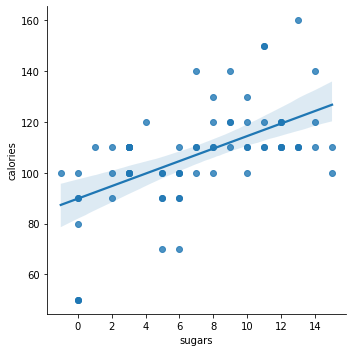

In [6]:
import seaborn as sns

sns.lmplot(x="sugars", y="calories", data=frame)
#sns.lmplot(x="protein", y="calories", data=frame)
#sns.lmplot(x="fat", y="calories", data=frame)
#sns.lmplot(x="carbo", y="calories", data=frame)

### Produisez les diagrammes à moustache (boxplot) de toutes les colonnes.

<AxesSubplot:>

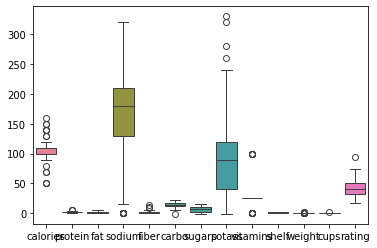

In [7]:
sns.boxplot(data=frame)

### Produisez les diagrammes à moustache de 5 colonnes seulement

<AxesSubplot:>

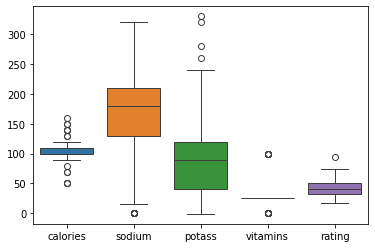

In [8]:
sns.boxplot(data=frame[["calories","sodium", "potass", "vitamins", "rating"]])

### Produisez un histogramme de l'une des colonnes

<AxesSubplot:xlabel='calories', ylabel='Count'>

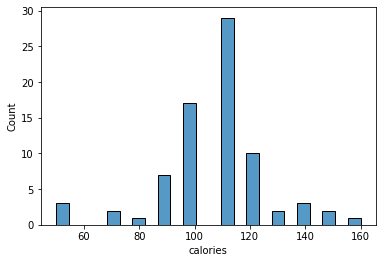

In [9]:
sns.histplot(frame.calories)

### Produire un diagramme d'une estimation par noyau (kernel density estimation plot)

<AxesSubplot:xlabel='sugars', ylabel='calories'>

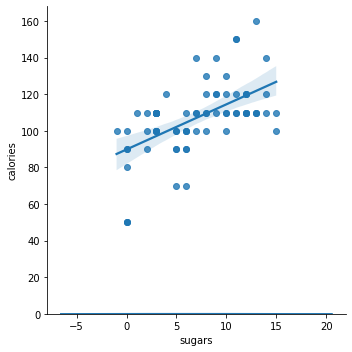

In [17]:
sns.lmplot(x="sugars", y="calories", data=frame)
sns.kdeplot(frame.sugars)

### Produire un diagramme croisant deux colonnes, de manière à la fois univariée et bivariée

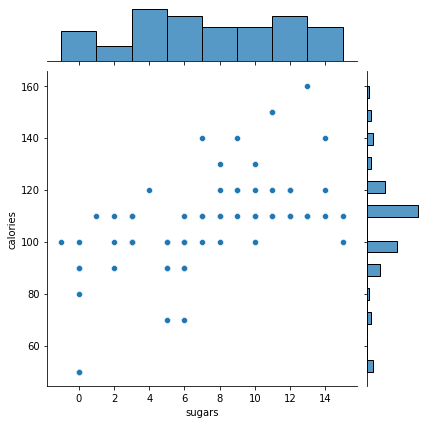

In [11]:
sns.jointplot(x="sugars", y="calories", data=frame)

### Divisez le dataset en 3 sous-groupe: entraînement (60% des échantillons), test (20%) et validation (20%). 

In [12]:
import random


#Default, all frame columns, default display
column1_name = "calories"
column2_name = "protein"
regression_frame = nutrition_frame

#Optional
#column1_name = "sugars"
#column2_name = "calories"
#nutrition_frame = nutrition_frame[[column1_name, column2_name]]


#Divide dataset
x = nutrition_frame.iloc[0:, 0:-1].astype(float)
y = frame["rating"]
indices = list(range(len(y)))
random.shuffle(indices)
random.shuffle(indices)
index_60pc = int(len(y) / 10 * 6)
index_80pc = int(len(y) / 10 * 8)

indices_train = indices[:index_60pc]
indices_cross = indices[index_60pc:index_80pc]
indices_test = indices[index_80pc:]

x_train = x.iloc[indices_train]
y_train = y.iloc[indices_train]
x_cross = x.iloc[indices_cross]
y_cross = y.iloc[indices_cross]
x_test  = x.iloc[indices_test ]
y_test  = y.iloc[indices_test ]

#print(x)
#print(x_train)

### Représentez pour chacun de ces groupes 3 colonnes dans un repère 3D avec matplotlib.

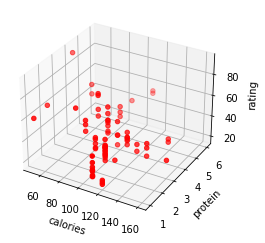

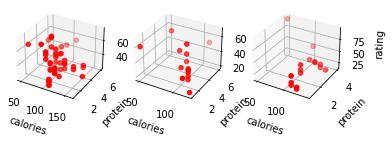

In [13]:
#convert x dataframe to x numpy array for matrix operations

model = LinearRegression(alpha=0.00003, n_cycle=3000, n_epoch=20, verbose=True, learning_rate_type='constant')

x       = np.array(x)
x_train = np.array(x_train)
x_cross = np.array(x_cross)
x_test  = np.array(x_test )

fig = mpl.figure()
model.plot_data_(x, y, fig, 111, "all", axis1_label=column1_name, axis2_label=column2_name, axis3_label="rating")
mpl.show()

model.plot_data_all_(x_train, y_train, x_cross, y_cross, x_test, y_test, axis1_label=column1_name, axis2_label=column2_name, axis3_label="rating")

### Entraînez un des modèles fournis ci-dessus sur la donnée.


Setup for training of linear model...
X_train column 0:

	- mode    : ModeResult(mode=array([110.]), count=array([15]))
	- mean    : 107.17391304347827
	- median  : 110.0
	- variance: 376.7958412098298
	- min     : 50.0
	- max     : 160.0
X_cross column 0:

	- mode    : ModeResult(mode=array([110.]), count=array([7]))
	- mean    : 100.0
	- median  : 110.0
	- variance: 306.6666666666667
	- min     : 50.0
	- max     : 120.0
X_test  column 0:

	- mode    : ModeResult(mode=array([110.]), count=array([7]))
	- mean    : 112.5
	- median  : 110.0
	- variance: 356.25
	- min     : 50.0
	- max     : 140.0
X_train column 1:

	- mode    : ModeResult(mode=array([3.]), count=array([18]))
	- mean    : 2.652173913043478
	- median  : 3.0
	- variance: 1.052930056710775
	- min     : 1.0
	- max     : 6.0
X_cross column 1:

	- mode    : ModeResult(mode=array([2.]), count=array([6]))
	- mean    : 2.466666666666667
	- median  : 2.0
	- variance: 1.5822222222222218
	- min     : 1.0
	- max     : 6.0
X_test  col

/tmp/ipykernel_1335001/1072641458.py:302: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  print("\t- mode    : " + str(stats.mode(column)))
/tmp/ipykernel_1335001/1072641458.py:313: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  print("\t- mode    : " + str(stats.mod

epoch 0: 	loss = 72083.49427770083
epoch 1: 	loss = 48.75319195961025
epoch 2: 	loss = 44.441607951857556
epoch 3: 	loss = 41.18301691382232
epoch 4: 	loss = 38.47341703636224
epoch 5: 	loss = 36.192719413878194
epoch 6: 	loss = 34.26376429963342
epoch 7: 	loss = 32.62629473725032
epoch 8: 	loss = 31.230966770715053
epoch 9: 	loss = 30.036957196088245
epoch 10: 	loss = 29.010418720816908
epoch 11: 	loss = 28.12327380705776
epoch 12: 	loss = 27.352227269941388
epoch 13: 	loss = 26.67794967532481
epoch 14: 	loss = 26.08440055521406
epoch 15: 	loss = 25.55826724975474
epoch 16: 	loss = 25.088499573062
epoch 17: 	loss = 24.6659239268848
epoch 18: 	loss = 24.28292329119304
epoch 19: 	loss = 23.93317184043029
Score on training dataset:	rmse: 6.8718869106585565	| r2_score: 0.6988803454075692
Score on crossval dataset:	rmse: 7.1056274115571165	| r2_score: 0.7202789122808134
Score on test     dataset:	rmse: 5.564119910251827	| r2_score: 0.8913473147822804
Final theta: [ 3.94453756  0.09738857  

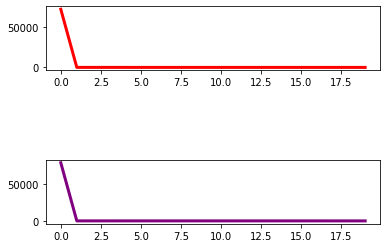

In [14]:
#Training
model = LinearRegression(alpha=0.00003, n_cycle=4000, n_epoch=20, verbose=True, learning_rate_type='constant')
model.train_(x_train, y_train, x_cross, y_cross, x_test, y_test, show_progress=False, show_hyperparameter_stats=True)

### Fournissez des métriques de qualité du modèle; et comparez les à ceux de l'équation normale (normalequation_).

In [15]:
print("RMSE before normal equation:\t" + str(model.rmse_(x_train, y_train)))
print("R2score before normal equation:\t" + str(model.r2score_(x_train, y_train)))
model.normalequation_(x, y)
print("theta after normal equation: " + str(model.theta))
print("RMSE after normal equation: " + str(model.rmse_(x_train, y_train)))
print("R2score after normal equation: " + str(model.r2score_(x_train, y_train)))


RMSE before normal equation:	6.8718869106585565
R2score before normal equation:	0.6988803454075692
theta after normal equation: [-0.21910993  4.21635142 -0.7850343  -0.06292167  5.45475833  1.36744393
 -0.71322043 -0.09312722 -0.10872152 36.27212094 16.45049768]
RMSE after normal equation: 5.574533722582912
R2score after normal equation: 0.8018453856356769


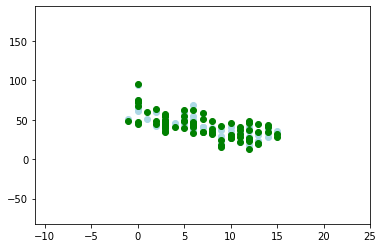

In [16]:
model.plot_model_multilinear_(regression_frame, nutrition_columns[0:-1], "sugars", "rating",
                              base_color="lightblue", prediction_color="green")
